# Intrusion Detection System
---

In [1]:
# TODO: define whether to use binary or multiclass classification
multiclass = False

## Load Data Split

In [2]:
import pandas as pd

X_train = pd.read_csv("../CICIDS2017/train_test_split/X_train_poc.csv")
X_test = pd.read_csv("../CICIDS2017/train_test_split/X_test_poc.csv")
if multiclass:
    y_train = pd.read_csv("../CICIDS2017/train_test_split/y_train_multiclass.csv")
    y_test = pd.read_csv("../CICIDS2017/train_test_split/y_test_multiclass.csv")
else:
    y_train = pd.read_csv("../CICIDS2017/train_test_split/y_train_poc.csv")
    y_test = pd.read_csv("../CICIDS2017/train_test_split/y_test_poc.csv")
    
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(192037, 68) (64013, 68) (192037, 2) (64013, 2)


### Create Validation Split for DNN Training

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(144027, 68) (48010, 68) (144027, 2) (48010, 2)


## Model Creation

In [5]:
# Create DNN model from tensorflow
import setuptools.dist # needed to avoid error
import tensorflow as tf
from tensorflow import keras

# normal keras model
# TODO: test with 40, 40, 20 and simple adam optimizer
# model = keras.Sequential()
# model.add(keras.layers.Dense(50, input_dim=X_train.shape[1], activation='relu')) # hidden layer
# model.add(keras.layers.Dense(30, activation='relu')) # hidden layer
# model.add(keras.layers.Dense(10, activation='relu')) # hidden layer
# model.add(keras.layers.Dense(1, activation='sigmoid')) # output layer

# keras model for handling one hot encoded labels -> needed for attack creation
model = keras.Sequential()
model.add(keras.layers.Dense(50, input_dim=X_train.shape[1], activation='relu')) # hidden layer
model.add(keras.layers.Dense(30, activation='relu')) # hidden layer
model.add(keras.layers.Dense(10, activation='relu')) # hidden layer
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))  # Output layer with softmax for one-hot encoding

# set learning rate
opt = keras.optimizers.Adam(learning_rate=0.001)
# compile the keras model
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Model Training

In [6]:
# fit the keras model on the dataset
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=100)

Epoch 1/10
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9406 - loss: 0.1689 - val_accuracy: 0.9908 - val_loss: 0.0186
Epoch 2/10
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9949 - loss: 0.0166 - val_accuracy: 0.9924 - val_loss: 0.0137
Epoch 3/10
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9967 - loss: 0.0114 - val_accuracy: 0.9947 - val_loss: 0.0110
Epoch 4/10
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9982 - loss: 0.0079 - val_accuracy: 0.9993 - val_loss: 0.0045
Epoch 5/10
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9984 - loss: 0.0067 - val_accuracy: 0.9991 - val_loss: 0.0038
Epoch 6/10
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9992 - loss: 0.0039 - val_accuracy: 0.9994 - val_loss: 0.0031
Epoch 7/10
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9991 - loss: 0.0039 - val_accuracy: 0.9994 - val_loss: 0.0026
Epoch 8/10
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9991 - loss: 0.0038 - 

## Result Visualization

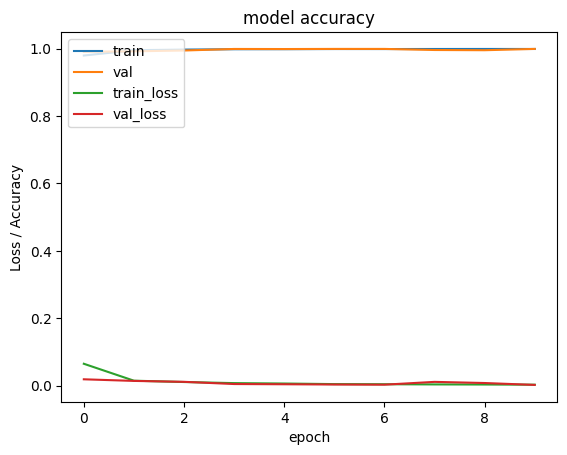

In [7]:
import matplotlib.pyplot as plt

history = model.history.history
# plot loss / accuracy vs epoch for train acc, validation acc, train loss, validation loss
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model accuracy')
plt.ylabel('Loss / Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'train_loss', 'val_loss'], loc='upper left')
plt.show()


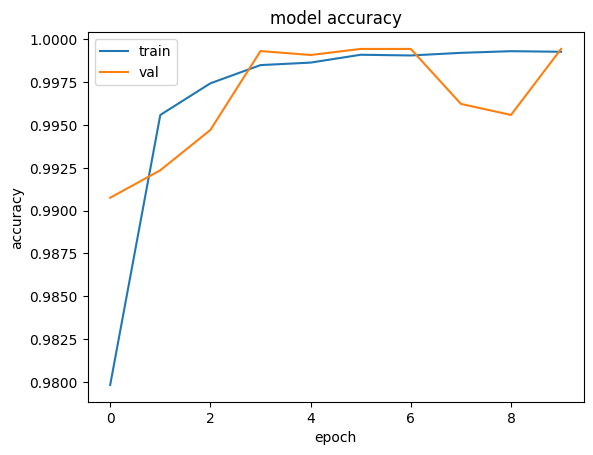

In [8]:
# plot training and validation accuracy over epochs
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluation

In [9]:
import json


def get_label_encoding():
    if multiclass:
        with open("../CICIDS2017/preprocessed/multiclass_label_encoding.json", "r") as file:
            class_mapping = json.load(file)
    else: 
        with open("../CICIDS2017/preprocessed/binary_label_encoding.json", "r") as file:
            class_mapping = json.load(file)
    target_names = [class_mapping[str(i)] for i in range(len(class_mapping))]
    return target_names

In [10]:
# print accuracy, precision, recall and f1-score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import numpy as np

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test.to_numpy(), axis=1)

# print accuracy
print(f"Global Accuracy: {accuracy_score(y_test_classes, y_pred_classes)*100:.2f}%")

# accuracy - one hot encoded
# [1, 0] == BENIGN
# [0, 1] == ATTACK
# print(f"Accuracy BENIGN: {accuracy_score(y_test[y_test['BENIGN'] == 1], y_pred[y_test['BENIGN'] == 1]):.2f}")
# print(f"Accuracy ATTACK: {accuracy_score(y_test[y_test['BENIGN'] == 0], y_pred[y_test['BENIGN'] == 0]):.2f}")
# print(f"Macro AVG Accuracy: {(accuracy_score(y_test[y_test['BENIGN'] == 1], y_pred[y_test['BENIGN'] == 1]) + accuracy_score(y_test[y_test['BENIGN'] == 0], y_pred[y_test['BENIGN'] == 0])) / 2:.2f}")
# print(f"Weighted AVG Accuracy: {accuracy_score(y_test, y_pred):.2f}")


# precision, recall, f1-score
print(classification_report(y_test_classes, y_pred_classes, target_names=get_label_encoding(), zero_division=0))


2001/2001 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Global Accuracy: 99.95%
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     31910
      ATTACK       1.00      1.00      1.00     32103

    accuracy                           1.00     64013
   macro avg       1.00      1.00      1.00     64013
weighted avg       1.00      1.00      1.00     64013



## Export Model

In [9]:
# export model
if multiclass:
    model.save('../CICIDS2017/models/ids_dnn_multiclass.keras')
else:
    model.save('../CICIDS2017/models/ids_dnn_poc.keras')